In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from transformers import AutoModel, AutoTokenizer
from sklearn.metrics import r2_score

c:\Users\user\anaconda3\envs\tensor\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 1. 데이터 준비 및 타겟 생성
df = pd.read_csv("C:/Users/user/fin_project/db/news(23-25)_summarized_external_clean.csv")  # 데이터셋 불러오기

In [3]:
# # test용
# df = df.sample(100, random_state=42).reset_index(drop=True)

In [4]:
# 다중 시점 종가를 타겟으로 설정
target_cols = ['D_plus_1_date_close', 'D_plus_2_date_close', 'D_plus_3_date_close', 'D_plus_7_date_close', 'D_plus_14_date_close']
df['target'] = df[target_cols].values.tolist()  # 각 row에 plus 종가가 리스트로 저장됨


In [5]:
external_cols = [
    'fx', 'bond10y', 'base_rate',
    'D_minus_14_date_volume', 'D_minus_14_date_foreign',
    'D_minus_14_date_institution', 'D_minus_14_date_individual',
    'D_minus_7_date_volume', 'D_minus_7_date_foreign',
    'D_minus_7_date_institution', 'D_minus_7_date_individual',
    'D_minus_3_date_volume', 'D_minus_3_date_foreign',
    'D_minus_3_date_institution', 'D_minus_3_date_individual',
    'D_minus_2_date_volume', 'D_minus_2_date_foreign',
    'D_minus_2_date_institution', 'D_minus_2_date_individual',
    'D_minus_1_date_volume', 'D_minus_1_date_foreign',
    'D_minus_1_date_institution', 'D_minus_1_date_individual'
]

In [6]:
from sklearn.preprocessing import StandardScaler
import numpy as np

# 1.1 훈련/검증 분할(데이터 누수 방지)
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# 1.2 타겟/외부 변수 스케일러 (훈련 데이터만으로 fit)
target_scaler = StandardScaler() # 타겟(5개 종가) 스케일링
external_scaler = StandardScaler() # 외부 변수(27개) 스케일링

# 검증 세트는 스케일러 학습에 전혀 사용 X

train_targets = np.array(train_df['target'].tolist())
train_externals = train_df[external_cols].values
target_scaler.fit(train_targets)
external_scaler.fit(train_externals)


StandardScaler()

In [7]:
# 2. 데이터셋 클래스
class NewsDataset(Dataset):
    def __init__(self, df, tokenizer, external_cols, target_scaler, external_scaler, max_len=512):
        self.texts = df['article_preprocessed'].tolist()
        self.external = torch.tensor(
            external_scaler.transform(df[external_cols].values), dtype=torch.float32 # 훈련 스케일러 적용
        )
        self.targets = torch.tensor(
            target_scaler.transform(np.array(df['target'].tolist())), dtype=torch.float32
        )
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        # return 시 squeeze 제거
        return {
            'input_ids': encoding['input_ids'][0],  # [1,512] → [512] 유지
            'attention_mask': encoding['attention_mask'][0],
            'external': self.external[idx]
        }, self.targets[idx]


In [8]:
# 3. 모델 정의 (다중 출력)
class NewsImportancePredictor(nn.Module):
    def __init__(self, embedding_model_name='snunlp/KR-SBERT-V40K-klueNLI-augSTS',
                 external_feature_dim=23, ae_hidden=256, ae_bottleneck=64,
                 fcl_hidden=512, dropout=0.2):
        super().__init__()
        self.bert = AutoModel.from_pretrained(embedding_model_name)
        self.tokenizer = AutoTokenizer.from_pretrained(embedding_model_name)
        self.encoder = nn.Sequential( # 768 → 256 → 64
            nn.Linear(768, ae_hidden),
            nn.GELU(),
            nn.Linear(ae_hidden, ae_bottleneck)
        )
        self.decoder = nn.Sequential(  # 64 → 256 → 768
            nn.Linear(ae_bottleneck, ae_hidden),
            nn.GELU(),
            nn.Linear(ae_hidden, 768)
        )
        self.predictor = nn.Sequential(
            nn.Linear(ae_bottleneck + external_feature_dim, fcl_hidden), # 잠재벡터 + 외부변수, fcl_hidden: 512
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(fcl_hidden, fcl_hidden//2),
            nn.GELU(),
            nn.Linear(fcl_hidden//2, 5)  # 5개 시점 주가 예측
        )

    def forward(self, input_ids, attention_mask, external):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        embeddings = outputs.last_hidden_state[:,0,:]
        latent = self.encoder(embeddings)
        reconstructed = self.decoder(latent)
        combined = torch.cat([latent, external], dim=1)
        pred = self.predictor(combined)
        return pred, reconstructed

In [9]:
# 4. 오토인코더 사전 학습
# 버트 임베딩 그대로 복원하도록 ae만 따로 학습
# 버트는 프리징

def train_autoencoder(model, dataloader, epochs=10, device='cuda'):
    ae_optimizer = torch.optim.AdamW(
        list(model.encoder.parameters()) + list(model.decoder.parameters()), lr=1e-4)
    criterion = nn.MSELoss()
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch in dataloader:
            input_ids = batch[0]['input_ids'].to(device)
            attention_mask = batch[0]['attention_mask'].to(device)
            with torch.no_grad(): # 버트 프리징
                bert_outputs = model.bert(input_ids=input_ids, attention_mask=attention_mask)
                bert_embeds = bert_outputs.last_hidden_state[:,0,:]
            latent = model.encoder(bert_embeds)
            reconstructed = model.decoder(latent)
            loss = criterion(reconstructed, bert_embeds)
            ae_optimizer.zero_grad()
            loss.backward()
            ae_optimizer.step()
            total_loss += loss.item()
        print(f"[AE] Epoch {epoch+1}/{epochs} | Loss: {total_loss/len(dataloader):.4f}")

In [10]:
def evaluate_metrics(preds, targets):
    mae = nn.L1Loss()(preds, targets).item()
    rmse = torch.sqrt(nn.MSELoss()(preds, targets)).item()
    return mae, rmse

def evaluate_r2(preds, targets):
    r2 = r2_score(targets, preds)
    return r2

def plot_loss(train_losses, val_losses):
    import matplotlib.pyplot as plt
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.legend()
    plt.show()

def train_predictor(model, train_loader, val_loader, target_scaler, device='cuda', epochs=50, patience=5):
    optimizer = torch.optim.AdamW(model.predictor.parameters(), lr=1e-5)
    criterion = nn.MSELoss()
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None

    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for batch in train_loader:
            input_ids = batch[0]['input_ids'].to(device)
            attention_mask = batch[0]['attention_mask'].to(device)
            external = batch[0]['external'].to(device)
            targets = batch[1].to(device)

            preds, _ = model(input_ids, attention_mask, external)
            loss = criterion(preds, targets)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        print(f"[Main] Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f}")

        model.eval()
        with torch.no_grad():
            val_loss = 0
            all_preds = []
            all_targets = []

            for batch in val_loader:
                input_ids = batch[0]['input_ids'].to(device)
                attention_mask = batch[0]['attention_mask'].to(device)
                external = batch[0]['external'].to(device)
                targets = batch[1].to(device)

                preds, _ = model(input_ids, attention_mask, external)
                loss = criterion(preds, targets)
                val_loss += loss.item()

                all_preds.append(preds.cpu())
                all_targets.append(targets.cpu())

            avg_val_loss = val_loss / len(val_loader)
            val_losses.append(avg_val_loss)

            all_preds = torch.cat(all_preds, dim=0).numpy()
            all_targets = torch.cat(all_targets, dim=0).numpy()

            # 스케일 역변환
            all_preds_inverse = target_scaler.inverse_transform(all_preds)
            all_targets_inverse = target_scaler.inverse_transform(all_targets)

            print("all_preds shape:", all_preds.shape)
            print("all_targets shape:", all_targets.shape)
            print("all_preds range: min =", all_preds.min(), ", max =", all_preds.max())
            print("all_targets range: min =", all_targets.min(), ", max =", all_targets.max())

            mae, rmse = evaluate_metrics(
                torch.tensor(all_preds_inverse, dtype=torch.float32),
                torch.tensor(all_targets_inverse, dtype=torch.float32)
            )
            r2 = evaluate_r2(all_preds_inverse, all_targets_inverse)

            print(f"        Validation Loss: {avg_val_loss:.4f} | MAE: {mae:.4f} | RMSE: {rmse:.4f} | R2: {r2:.4f}")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            best_model_state = model.state_dict()
        else:
            patience_counter += 1
            print(f"        EarlyStopping patience {patience_counter}/{patience}")
            if patience_counter >= patience:
                print(f"        EarlyStopping triggered at epoch {epoch+1}!")
                if best_model_state is not None:
                    model.load_state_dict(best_model_state)
                break

    plot_loss(train_losses, val_losses)

[AE] Epoch 1/5 | Loss: 0.4498
[AE] Epoch 2/5 | Loss: 0.3301
[AE] Epoch 3/5 | Loss: 0.2957
[AE] Epoch 4/5 | Loss: 0.2756
[AE] Epoch 5/5 | Loss: 0.2604
[Main] Epoch 1/10 | Train Loss: 1.0044
all_preds shape: (2692, 5)
all_targets shape: (2692, 5)
all_preds range: min = -0.8100724 , max = 0.8192805
all_targets range: min = -0.68108916 , max = 11.708527
        Validation Loss: 1.0380 | MAE: 100010.2812 | RMSE: 166609.9219 | R2: 0.0218
[Main] Epoch 2/10 | Train Loss: 0.9725
all_preds shape: (2692, 5)
all_targets shape: (2692, 5)
all_preds range: min = -0.83106035 , max = 0.6629263
all_targets range: min = -0.68108916 , max = 11.708527
        Validation Loss: 1.0062 | MAE: 96879.8203 | RMSE: 164041.3750 | R2: 0.0517
[Main] Epoch 3/10 | Train Loss: 0.9446
all_preds shape: (2692, 5)
all_targets shape: (2692, 5)
all_preds range: min = -0.9686495 , max = 0.5677088
all_targets range: min = -0.68108916 , max = 11.708527
        Validation Loss: 0.9800 | MAE: 93180.5938 | RMSE: 161896.2656 | R2: 

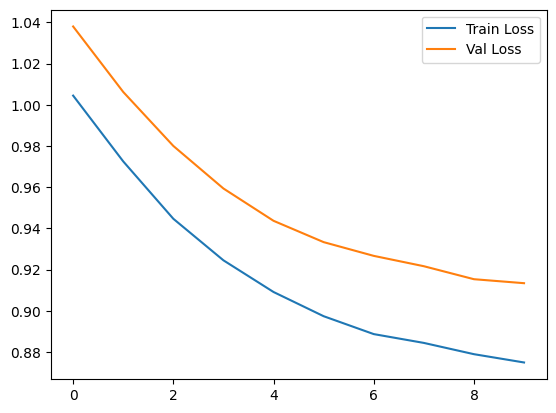

In [11]:
# 6. 전체 파이프라인 실행
if __name__ == "__main__":
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = NewsImportancePredictor(external_feature_dim=len(external_cols)).to(device)
    # 훈련 / 검증 분리
    dataset_train = NewsDataset(
        train_df,
        model.tokenizer,
        external_cols,
        target_scaler,  # 훈련 데이터로 피팅된 스케일러
        external_scaler # 훈련 데이터로 피팅된 스케일러
        )
    dataset_val = NewsDataset(
        val_df,
        model.tokenizer,
        external_cols,
        target_scaler, # 동일 스케일러 사용!
        external_scaler # 동일 스케일러 사용!
        )

    # DataLoader
    ae_train_loader = DataLoader(dataset_train, batch_size=16, shuffle=True)
    train_loader = DataLoader(dataset_train, batch_size=16, shuffle=True)
    val_loader = DataLoader(dataset_val, batch_size=32)

    # 1) 오토인코더 사전학습
    train_autoencoder(model, ae_train_loader, epochs=5, device=device)

    # 2) 주요 예측기 학습 (얼리스타핑)
    train_predictor(model, train_loader, val_loader, target_scaler, device=device, epochs=10, patience=3)

In [12]:
df

,news_id,wdate,title,article,press,url,image,article_preprocessed,summary,stock_list,...,D_plus_14_date_foreign,D_plus_14_date_institution,D_plus_14_date_individual,D_day_date_open,D-day_change_open,D-day_change,fx,bond10y,base_rate,target
0,20240101_0049,2024-01-01 06:03:00,태영건설 파장 속 PF-ABCP '거래 부진'…차환 우려 고개,"PF 구조조정에 건설업 기피심리↑…""익숙한 악재라 파장 적을 것"" 관측도\n워크아웃...",연합뉴스,https://n.news.naver.com/mnews/article/001/001...,https://imgnews.pstatic.net/image/001/2024/01/...,시공능력 순위 16위의 중견기업인 태영건설이 워크아웃을 신청하면서 부동산 PF 부실...,시공능력 순위 16위의 중견기업인 태영건설이 워크아웃을 신청하면서 부동산 PF 부실...,['태영건설'],...,2.411097e+08,2.445000e+03,-2.413366e+08,4638.0,14.920224,13.163482,1289.4,3.154,3.50,"[6602.0, 6246.0, 6287.0, 7660.0, 4872.0]"
1,20240101_0001,2024-01-01 18:30:00,통합 셀트리온 12일 상장… 잭팟 터지나,합병 전 외국인·기관 동반 매수\n올해 영업익 1조5130억 전망\n최근 증시 상승...,파이낸셜뉴스,https://n.news.naver.com/mnews/article/014/000...,https://imgnews.pstatic.net/image/014/2024/01/...,새해 출범하는 '통합 셀트리온'에 대한 기대감이 커지는 것으로 풀이된다. 외국인과 ...,외국인과 기관이 지난해 12월 삼성전자 주식을 1조4267억원어치 사들이며 전체 주...,['삼성전자'],...,1.372444e+11,-1.237386e+10,-1.303683e+11,78200.0,1.790281,1.401274,1289.4,3.154,3.50,"[77000.0, 76600.0, 76600.0, 73200.0, 75100.0]"
2,20240101_0032,2024-01-01 11:21:00,"외인·기관 홀린 '합병 셀트리온', 새해 잭팟 터트리나","[파이낸셜뉴스] 최근 증시 상승을 이끈 외국인, 기관 투자자들이 셀트리온그룹주를 순...",파이낸셜뉴스,https://n.news.naver.com/mnews/article/014/000...,https://imgnews.pstatic.net/image/014/2024/01/...,새해 출범하는 '합병 셀트리온'에 대한 기대감이 커지는 것으로 풀이된다. 외국인과 ...,외국인과 기관이 지난해 12월 삼성전자 주식을 1조4267억원어치 사들이며 전체 주...,"['삼성전자', '셀트리온']",...,-2.332484e+10,3.074480e+10,-7.904098e+09,194360.0,13.759518,14.888542,1289.4,3.154,3.50,"[221103.0, 208209.0, 204867.0, 195793.0, 17535..."
3,20240101_0017,2024-01-01 17:45:00,"김·김치·라면 '수출 대박'…""올핸 떡볶이·핫도그가 대열 합류""",■'차세대 한류' 노리는 식품업계\n라면·김 작년 수출액 1조원 돌파\n역대급 실적...,서울경제,https://n.news.naver.com/mnews/article/011/000...,https://imgnews.pstatic.net/image/011/2024/01/...,■'차세대 한류' 노리는 식품업계 라면·김 작년 수출액 1조원 돌파 역대급 실적에 ...,"CJ 제일001040) 제일제당은 유럽, 호주 등에서 영토를 넓힘과 동시에 오카도,...",['농심'],...,1.764586e+09,-1.128099e+09,-6.181225e+08,407000.0,1.351351,1.351351,1289.4,3.154,3.50,"[410500.0, 408000.0, 402000.0, 393500.0, 37550..."
4,20240101_0011,2024-01-01 18:15:00,"""빅딜 절호의 기회"" 새해부터 분주한 K제약바이오",'JP모건 헬스케어 컨퍼런스'\n삼바·셀트리온 등 대거 참여\n기술력 알리고 협력기...,파이낸셜뉴스,https://n.news.naver.com/mnews/article/014/000...,https://ssl.pstatic.net/static.news/image/news...,'JP모건 헬스케어 컨퍼런스' 삼바·셀트리온 등 대거 참여 기술력 알리고 협력기회 ...,오는 8일부터 미국 샌프란시스코에서 열리는 'JP모건 헬스케어 컨퍼런스'에 참여하는...,"['한미약품', '유한양행']",...,3.324466e+09,-4.505191e+09,1.293182e+09,68800.0,-1.453488,-1.453488,1289.4,3.154,3.50,"[68800.0, 66300.0, 65900.0, 65300.0, 59600.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13454,20250515_0111,2025-05-15 12:00:00,작년말 보험사 지급여력비율 뚝…1분기 순이익도 15% 감소,"금감원 ""하반기 기본자본 규제 구체안 마련…롯데손보 자본확충 긴밀히 협의""\n보험사...",연합뉴스,https://n.news.naver.com/mnews/article/001/001...,https://imgnews.pstatic.net/image/001/2025/05/...,금융당국은 보험사 건전성과 관련해 자본 규제를 합리화하는 한편 최근 논란이 된 롯데...,금융당국은 보험사 건전성과 관련해 자본 규제를 합리화하고 최근 논란이 된 롯데손해보...,['롯데손해보험'],...,6.540265e+07,-5.385719e+07,-1.144005e+07,1594.0,-1.066499,-1.375860,1415.8,2.362,2.75,"[1528.0, 1538.0, 1551.0, 1590.0, 1694.0]"
13455,20250515_0010,2025-05-15 18:35:00,"PKC, 영업이익 33억원…전년 대비 9%↑",종합 화학 신소재 개발·제조 전문기업 PKC가 올해 영업이익이 9% 이상 늘어났다고...,머니투데이,https://n.news.naver.com/mnews/article/008/000...,https://imgnews.pstatic.net/image/008/2025/05/...,이번 실적은 △CA 제품군의 견조한 수요 △고순도제품의 판매 확대 △제품 믹스 개선...,1954년 설립된 PKC는 오랜 업력 기반의 화학 제품 생산 기술을 갖추고 있으며 ...,['PKC'],...,3.779150e+07,3.643100e+05,-3.815582e+07,6070.0,-1.482702,-0.993377,1415.8,2.362,2.75,"[5830.0, 5760.0, 5710.0, 5570.0, 5860.0]"
13456,20250515_0009,2025-05-15 18:52:00,"유안타증권, FDS 고도화 한달간 5억원 피싱 막았다",유안타증권은 지난달 'FDS(이상금융거래탐지시스템) 고도화' 한 달여 동안 약 5억...,파이낸셜뉴스,https://n.news.naver.com/mnews/article/014/000...,https://ssl.pstatic.net/static.news/image/news...,유안타증권은 지난달 'FDS(이상금융거래탐지시스템) 고도화' 한 달여 동안 약 5억...,"유안타증권이 고객의 단말기 및 접속 정보, 그 외 거래 정보 등 다양한 데이터를 종...",['유안타증권'],...,

모델 저장

스케일러 저장

토크나이저 저장

ONNX 변환

BasicWordpieceTokenizer 클래스 정의

토크나이저, 스케일러, ONNX 모델 로드

예측 함수 정의

예측 함수 사용 예시(main)

In [13]:
import torch
import pickle
import os
from transformers import AutoTokenizer

# 모델 저장
os.makedirs('./saved_models', exist_ok=True)
torch.save(model.state_dict(), './saved_models/model_weights.pth')  

# 스케일러 저장
with open('./saved_models/target_scaler.pkl', 'wb') as f:
    pickle.dump(target_scaler, f)  # [3][8]
with open('./saved_models/external_scaler.pkl', 'wb') as f:
    pickle.dump(external_scaler, f)

# 토크나이저 저장
model.tokenizer.save_pretrained('./saved_models')  # transformers 토크나이저라면
# 이러면 vocab.txt, tokenizer_config.json, special_tokens_map.json 등이 저장됨



('./saved_models\\tokenizer_config.json',
 './saved_models\\special_tokens_map.json',
 './saved_models\\vocab.txt',
 './saved_models\\added_tokens.json',
 './saved_models\\tokenizer.json')

# onnx 수정버전

In [16]:
# 토크나이저 저장
model.tokenizer.save_pretrained('./saved_models')  # transformers 토크나이저라면
# 이러면 vocab.txt, tokenizer_config.json, special_tokens_map.json 등이 저장됨

('./saved_models\\tokenizer_config.json',
 './saved_models\\special_tokens_map.json',
 './saved_models\\vocab.txt',
 './saved_models\\added_tokens.json',
 './saved_models\\tokenizer.json')

In [14]:
import torch
import onnx
import os

# Make sure the model is in evaluation mode
model.eval()

# Example: BERT 기반 모델, 외부 변수 23개
# 실제 vocab_size 반영
vocab_size = model.tokenizer.vocab_size
dummy_input_ids = torch.randint(0, vocab_size, (1, 512)).to(device) # input_ids
dummy_attention_mask = torch.ones(1, 512, dtype=torch.int64).to(device) # attention_mask
dummy_external = torch.randn(1, len(external_cols)).to(device) # 외부 변수, ensure correct dim

try:
    torch.onnx.export(
        model,
        (dummy_input_ids, dummy_attention_mask, dummy_external), # Pass as a tuple of arguments
        './saved_models/news_predictor.onnx',
        input_names=['input_ids', 'attention_mask', 'external'],
        output_names=['pred', 'reconstructed'],
        dynamic_axes={
            'input_ids': {0: 'batch_size', 1: 'sequence_length'},
            'attention_mask': {0: 'batch_size', 1: 'sequence_length'},
            'external': {0: 'batch_size'},
            'pred': {0: 'batch_size'},
            'reconstructed': {0: 'batch_size'}
        },
        opset_version=17,
        do_constant_folding=True
    )
    print("ONNX model exported successfully!")
except Exception as e:
    print(f"Error during ONNX export: {e}")

# ONNX 모델 검증
try:
    model_onnx = onnx.load("./saved_models/news_predictor.onnx")
    onnx.checker.check_model(model_onnx)
    print("ONNX 모델 검증 완료!")
except Exception as e:
    print(f"Error during ONNX model validation: {e}")

ONNX model exported successfully!
ONNX 모델 검증 완료!


In [15]:
import numpy as np

class BasicWordpieceTokenizer:
    def __init__(self, vocab_path, unk_token='[UNK]', cls_token='[CLS]', sep_token='[SEP]', pad_token='[PAD]'):
        self.vocab = self.load_vocab(vocab_path)
        self.inv_vocab = {v: k for k, v in self.vocab.items()}
        self.unk_token = unk_token
        self.cls_token = cls_token
        self.sep_token = sep_token
        self.pad_token = pad_token

    def load_vocab(self, vocab_path):
        vocab = {}
        with open(vocab_path, encoding='utf-8') as f:
            for i, line in enumerate(f):
                token = line.strip()
                vocab[token] = i
        return vocab

    def tokenize(self, text):
        # 아주 단순하게 공백 기준 토큰화 후, vocab에 없으면 [UNK]
        # 실제 WordPiece 알고리즘을 쓰려면 더 복잡하게 구현 가능
        return [token if token in self.vocab else self.unk_token for token in text.strip().split()]

    def encode(self, text, max_length=512):
        tokens = [self.cls_token] + self.tokenize(text)[:max_length-2] + [self.sep_token]
        input_ids = [self.vocab.get(token, self.vocab[self.unk_token]) for token in tokens]
        attention_mask = [1] * len(input_ids)
        # 패딩
        while len(input_ids) < max_length:
            input_ids.append(self.vocab[self.pad_token])
            attention_mask.append(0)
        input_ids = input_ids[:max_length]
        attention_mask = attention_mask[:max_length]
        return {
            'input_ids': np.array([input_ids], dtype=np.int64),
            'attention_mask': np.array([attention_mask], dtype=np.int64)
        }


onnx 사용예시

In [ ]:
import onnxruntime as ort
import numpy as np
import pickle

# 1. 토크나이저 준비
tokenizer = BasicWordpieceTokenizer('./saved_models/vocab.txt')

# 2. 스케일러 로드
with open('./saved_models/external_scaler.pkl', 'rb') as f:
    external_scaler = pickle.load(f)
with open('./saved_models/target_scaler.pkl', 'rb') as f:
    target_scaler = pickle.load(f)

# 3. ONNX 모델 로드
ort_session = ort.InferenceSession('./saved_models/news_predictor.onnx', providers=['CPUExecutionProvider'])

# 4. 예측 함수
def predict(news_text, external_data):
    # 텍스트 토큰화
    inputs = tokenizer.encode(news_text, max_length=512)
    # 외부 변수 스케일링
    external_scaled = external_scaler.transform([external_data]).astype(np.float32)
    # ONNX 입력
    onnx_inputs = {
        'input_ids': inputs['input_ids'],
        'attention_mask': inputs['attention_mask'],
        'external': external_scaled
    }
    # 추론
    pred = ort_session.run(['pred'], onnx_inputs)[0]
    # 역스케일링
    return target_scaler.inverse_transform(pred)[0]


In [ ]:
import pandas as pd
import numpy as np
import onnxruntime as ort
import pickle

# # --- BasicWordpieceTokenizer 클래스가 여기에 정의되어 있거나 임포트되었다고 가정합니다 ---
# class BasicWordpieceTokenizer:
#     def __init__(self, vocab_path, unk_token='[UNK]', cls_token='[CLS]', sep_token='[SEP]', pad_token='[PAD]'):
#         self.vocab = self.load_vocab(vocab_path)
#         self.inv_vocab = {v: k for k, v in self.vocab.items()}
#         self.unk_token = unk_token
#         self.cls_token = cls_token
#         self.sep_token = sep_token
#         self.pad_token = pad_token

#     def load_vocab(self, vocab_path):
#         vocab = {}
#         with open(vocab_path, encoding='utf-8') as f:
#             for i, line in enumerate(f):
#                 token = line.strip()
#                 vocab[token] = i
#         return vocab

#     def tokenize(self, text):
#         return [token if token in self.vocab else self.unk_token for token in text.strip().split()]

#     def encode(self, text, max_length=512):
#         tokens = [self.cls_token] + self.tokenize(text)[:max_length-2] + [self.sep_token]
#         input_ids = [self.vocab.get(token, self.vocab[self.unk_token]) for token in tokens]
#         attention_mask = [1] * len(input_ids)
#         while len(input_ids) < max_length:
#             input_ids.append(self.vocab[self.pad_token])
#             attention_mask.append(0)
#         input_ids = input_ids[:max_length]
#         attention_mask = attention_mask[:max_length]
#         return {
#             'input_ids': np.array([input_ids], dtype=np.int64),
#             'attention_mask': np.array([attention_mask], dtype=np.int64)
#         }
# # ----------------------------------------------------------------------


# 1. 토크나이저, 스케일러 로드
tokenizer = BasicWordpieceTokenizer('./saved_models/vocab.txt')

with open('./saved_models/external_scaler.pkl', 'rb') as f:
    external_scaler = pickle.load(f)
with open('./saved_models/target_scaler.pkl', 'rb') as f:
    target_scaler = pickle.load(f)

# 3. ONNX 모델 로드 (GPU 지원 추가)
# GPU(CUDA)를 우선적으로 사용하고, GPU를 사용할 수 없을 때만 CPU를 사용하도록 설정합니다.
try:
    ort_session = ort.InferenceSession('./saved_models/news_predictor.onnx', providers=['CUDAExecutionProvider', 'CPUExecutionProvider'])
    print("ONNX Runtime 세션이 GPU(CUDA) 또는 CPU를 사용하여 로드되었습니다.")
except Exception as e:
    print(f"ONNX Runtime 세션 로드 중 오류 발생: {e}")
    print("GPU(CUDA) 환경 설정 또는 onnxruntime-gpu 설치를 확인해주세요.")
    # 오류 발생 시 CPU로만 다시 시도할 수도 있습니다.
    ort_session = ort.InferenceSession('./saved_models/news_predictor.onnx', providers=['CPUExecutionProvider'])
    print("GPU 로드 실패: CPUExecutionProvider로 다시 로드되었습니다.")


# external_cols 정의 (DataFrame에서 컬럼 선택 시 필요)
external_cols = [
    'fx', 'bond10y', 'base_rate',
    'D_minus_14_date_volume', 'D_minus_14_date_foreign',
    'D_minus_14_date_institution', 'D_minus_14_date_individual',
    'D_minus_7_date_volume', 'D_minus_7_date_foreign',
    'D_minus_7_date_institution', 'D_minus_7_date_individual',
    'D_minus_3_date_volume', 'D_minus_3_date_foreign',
    'D_minus_3_date_institution', 'D_minus_3_date_individual',
    'D_minus_2_date_volume', 'D_minus_2_date_foreign',
    'D_minus_2_date_institution', 'D_minus_2_date_individual',
    'D_minus_1_date_volume', 'D_minus_1_date_foreign',
    'D_minus_1_date_institution', 'D_minus_1_date_individual'
]

# 2. 전처리 함수 정의
def preprocess_input(news_text, external_data_list):
    tokenized_inputs = tokenizer.encode(news_text, max_length=512)
    external_scaled = external_scaler.transform([external_data_list]).astype(np.float32)
    onnx_inputs = {
        'input_ids': tokenized_inputs['input_ids'],
        'attention_mask': tokenized_inputs['attention_mask'],
        'external': external_scaled
    }
    return onnx_inputs

# 3. 후처리 함수 정의
def postprocess_output(predicted_scaled_output):
    original_scale_prediction = target_scaler.inverse_transform(predicted_scaled_output)[0]
    return original_scale_prediction


In [ ]:
# --- 실제 데이터 프레임 불러와서 테스트 ---
try:
    df = pd.read_csv("C:/Users/user/fin_project/db/news(23-25)_summarized_external_clean.csv")
    print("DataFrame이 성공적으로 로드되었습니다.")

    row_data = df.iloc[5473]

    news_text = row_data['article_preprocessed']
    external_data_for_prediction = row_data[external_cols].values.tolist()

    inputs = preprocess_input(news_text, external_data_for_prediction)

    # ONNX 모델 추론
    pred_scaled = ort_session.run(['pred'], inputs)[0]

    # 예측 결과 후처리 (역스케일링)
    result = postprocess_output(pred_scaled)

    print(f"\n뉴스 텍스트:\n{news_text[:200]}...")
    print(f"\n원본 외부 변수: {external_data_for_prediction}")
    print(f"\n예측 주가 (D+1, D+2, D+3, D+7, D+14): {result}")

except FileNotFoundError:
    print("오류: 데이터 파일을 찾을 수 없습니다. 경로를 확인해주세요: C:/Users/user/fin_project/db/news(23-25)_summarized_external_clean.csv")
except KeyError as e:
    print(f"오류: DataFrame에서 필요한 컬럼을 찾을 수 없습니다. 컬럼 이름이 올바른지 확인해주세요: {e}")
except Exception as e:
    print(f"데이터 로드 또는 예측 중 오류 발생: {e}")

이 밑으로는 혹시몰라서 아카이브

In [ ]:
# import os
# import pickle

# save_dir = "./saved_models"
# os.makedirs(save_dir, exist_ok=True)

# # 이미 학습된 model, target_scaler, external_scaler가 메모리에 있다면 바로 저장 가능
# torch.save(model.state_dict(), os.path.join(save_dir, "model_weights.pth"))

# # ONNX 변환을 위한 더미 입력 생성
# sample_text = "주식 시장 분석을 위한 예시 뉴스 텍스트"
# tokenizer = AutoTokenizer.from_pretrained('snunlp/KR-SBERT-V40K-klueNLI-augSTS')
# inputs = tokenizer(
#     sample_text,
#     max_length=512,
#     padding='max_length',
#     truncation=True,
#     return_tensors='pt'
# )
# external_dummy = torch.randn(1, len(external_cols))  # 외부 변수 더미

# # ONNX 변환 전 모델을 CPU로 이동
# model = model.to('cpu')

# # ONNX 변환 실행
# torch.onnx.export(
#     model,
#     (inputs['input_ids'], inputs['attention_mask'], external_dummy),
#     os.path.join(save_dir, "news_predictor.onnx"),
#     input_names=['input_ids', 'attention_mask', 'external'],
#     output_names=['pred', 'reconstructed'],
#     dynamic_axes={
#         'input_ids': {0: 'batch_size', 1: 'sequence_length'},
#         'attention_mask': {0: 'batch_size', 1: 'sequence_length'},
#         'external': {0: 'batch_size'},
#         'pred': {0: 'batch_size'},
#         'reconstructed': {0: 'batch_size'}
#     },
#     opset_version=17
# )

# # 스케일러 저장
# with open(os.path.join(save_dir, "target_scaler.pkl"), "wb") as f:
#     pickle.dump(target_scaler, f)
# with open(os.path.join(save_dir, "external_scaler.pkl"), "wb") as f:
#     pickle.dump(external_scaler, f)

# print("ONNX 변환 및 모델 저장 완료!")



ONNX 추론 실행
- 전처리 후처리 함수 필수라서 지우면 안 된다함

In [ ]:
# import pickle
# from transformers import AutoTokenizer
# import onnxruntime as ort
# import numpy as np

# # 전처리 함수
# def preprocess_input(news_text, external_data):
#     tokenizer = AutoTokenizer.from_pretrained('snunlp/KR-SBERT-V40K-klueNLI-augSTS')
#     inputs = tokenizer(
#         news_text,
#         max_length=512,
#         padding='max_length',
#         truncation=True,
#         return_tensors='np'
#     )
#     with open("saved_models/external_scaler.pkl", "rb") as f:
#         external_scaler = pickle.load(f)
#     external_scaled = external_scaler.transform([external_data])
#     return {
#         'input_ids': inputs['input_ids'].astype(np.int64),
#         'attention_mask': inputs['attention_mask'].astype(np.int64),
#         'external': external_scaled.astype(np.float32)
#     }

# # 후처리 함수
# def postprocess_output(pred):
#     with open("saved_models/target_scaler.pkl", "rb") as f:
#         target_scaler = pickle.load(f)
#     pred_inverse = target_scaler.inverse_transform(pred)
#     return {
#         'D_plus_1': pred_inverse[0][0],
#         'D_plus_2': pred_inverse[0][1],
#         'D_plus_3': pred_inverse[0][2],
#         'D_plus_7': pred_inverse[0][3],
#         'D_plus_14': pred_inverse[0][4]
#     }

# # ONNX 추론 예시
# ort_session = ort.InferenceSession("saved_models/news_predictor.onnx")


# onnx 테스트

In [ ]:
# # --------------------------------------------test

# row_data = df.iloc[56]
# news_text = row_data['article_preprocessed']
# external_data = row_data[external_cols].values.tolist()  # 원본 데이터

# inputs = preprocess_input(news_text, external_data) 
# pred = ort_session.run(['pred'], inputs)[0]
# result = postprocess_output(pred)

# print(result)

더미테스트

In [ ]:
# 1. 데이터 준비 및 타겟 생성
dum = pd.read_csv("C:/Users/user/fin_project/db/news(23-25)_summarized_external_clean.csv")  # 데이터셋 불러오기

In [ ]:
# # --------------------------------------------test

row_data = dum.iloc[5473]
news_text = row_data['article_preprocessed']
external_data = row_data[external_cols].values.tolist()  # 원본 데이터

inputs = preprocess_input(news_text, external_data) 
pred = ort_session.run(['pred'], inputs)[0]
result = postprocess_output(pred)

print(result)

In [ ]:
# # 최대 열 개수 설정 (None으로 하면 모든 열 보임)
# pd.set_option('display.max_columns', None)

In [ ]:
# d = dum.iloc[5473]
# df_single = d.to_frame().T
# df_single.info()

In [ ]:
# d_plus_close_columns = [col for col in df_single.columns if col.startswith('D_plus_') and col.endswith('_close')]
# df_single[d_plus_close_columns]


saved_models/  
├── full_model.pth        # 전체 모델 구조+가중치  
├── model_weights.pth     # 가중치만  
├── target_scaler.pkl     # 타겟 스케일러  
└── external_scaler.pkl   # 외부 변수 스케일러  
